Hi there! This is my first kernel dealing with textual data so any constructive feedabacks are higly appreciated.

This dataset contains data of over 7 topics namely biology, robotics, cryptography, diy, travel, cooking, robotics and physics extracted from Stack Exchange. Each of these topics except physics have been classified as to which topic data belongs. So our task is to do predictions on unseen physics questions.

Since our data won't be related to each other for example tags in travel won't be related to tags in cryptography hence I will be using unsupervised learning on physics dataset which is the test dataset. 

In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer 

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import silhouette_score


['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA-BUG.csv', 'JIRA.csv', 'preprocessed_data.csv']


Making dictionary to put all the data in the same hood.

In [2]:
data=pd.read_csv('Input/JIRA-BUG.csv')
data = data.reset_index()
data.head()

,index,Summary,Bug Location,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,...,Comment.64,Comment.65,Comment.66,Comment.67,Comment.68,Comment.69,Comment.70,Parent,Parent summary,Status Category
0,0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,Admin Portal,CORE-4396,57063,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
1,1,[Dev][Admin Portal][Create New][Create From ex...,Admin Portal,CORE-4385,57039,Bug,In Progress,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
2,2,Duplicate items while using Search items by ke...,Automation Test,CORE-4377,57007,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
3,3,[AP] Default language and default region of st...,Admin Portal,CORE-4366,56971,Bug,QA,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
4,4,[Unity][SDK] Single draft store makes subscrip...,SDK,CORE-4365,56960,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do


In [3]:
cols_of_interest=["Summary", "Status","Description","Priority","Resolution", "Issue Type", "Bug Location"]
data=data[cols_of_interest]
print(data.shape)
data.head()

(651, 7)


,Summary,Status,Description,Priority,Resolution,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,NaN,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,NaN,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,NaN,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,NaN,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,NaN,Bug,SDK


In [4]:
data.Description = data.Description.fillna("0")
data.isnull().sum()

Summary          0
Status           0
Description      0
Priority         0
Resolution      97
Issue Type       0
Bug Location     0
dtype: int64

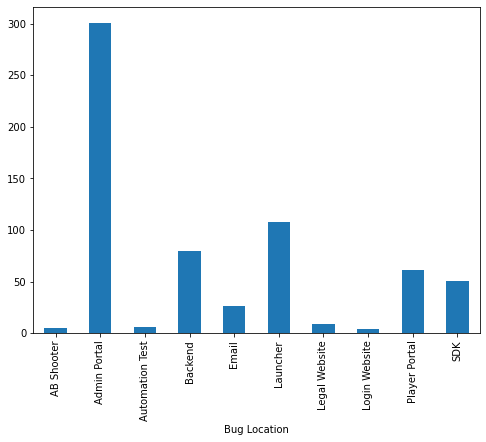

In [5]:
fig = plt.figure(figsize=(8,6))
data.groupby('Bug Location').Summary.count().plot.bar(ylim=0)
plt.show()

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

5-Vectorization (either using TfidVectorizer or Countvectorizer in sklearn.feature_extraction.text or word embeddings) Changing text data into vector format.


In [6]:
stops = set(stopwords.words("english"))

In [7]:
data.Concat = data.Summary +" "+ data.Description+" "+data["Bug Location"]+" "+data.Status
data.Concat.to_csv("./Output/data_concat.csv")

<ipython-input-7-670f5c579b8e>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.Concat = data.Summary +" "+ data.Description+" "+data["Bug Location"]+" "+data.Status


In [8]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

Applying operations on data

In [9]:
# data['bug']
data.Concat = clean_Description(data.Concat)
data.head()

,Summary,Status,Description,Priority,Resolution,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,NaN,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,NaN,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,NaN,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,NaN,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,NaN,Bug,SDK


 Visualizing our cleaned data using WordCloud

## Stemming

In [10]:
wordnet = WordNetLemmatizer()
data.Concat = data.Concat.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])
data.head()

,Summary,Status,Description,Priority,Resolution,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,NaN,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,NaN,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,NaN,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,NaN,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,NaN,Bug,SDK


Vectrorizing data using TfidVectrorizer which uses the concept of term frequency and inverse document frequency to get rid of all non-consequential tokens from being vectorized.
For more details see https://www.quora.com/How-does-TfidfVectorizer-work-in-laymans-terms

In [11]:
def identity_tokenizer(text):
  return text
vect = TfidfVectorizer(tokenizer=identity_tokenizer,lowercase=False)
x = vect.fit_transform(data.Concat.values)

In [12]:
indices = np.argsort(vect.idf_)[::-1]
features = vect.get_feature_names()
top_n = 50
top_features = [features[i] for i in indices[:top_n]]
top_features

['zone',
 'paymentorderno',
 'nru',
 'ns',
 'numberlong',
 'numeric',
 'coroutine',
 'objectid',
 'corner',
 'often',
 'okcontent',
 'onclose',
 'conversation',
 'ones',
 'ongoing',
 'controller',
 'openid',
 'npe',
 'notnull',
 'cost',
 'creat',
 'creator',
 'createuserhandlerv',
 'newtopic',
 'nil',
 'nitrado',
 'nod',
 'crds',
 'countries',
 'nopolicyversions',
 'normally',
 'notfound',
 'notfoundkey',
 'coverage',
 'noticeable',
 'openning',
 'openshift',
 'operation',
 'particular',
 'paramater',
 'parameterize',
 'paramkey',
 'paramvalue',
 'parnurzeal',
 'console',
 'consider',
 'panic',
 'partyformed',
 'partystoragetests',
 'consent']

**k-means clustering**

In general, k-means is the first choice for clustering because of its simplicity. Here, the user has to define the number of clusters (Post on how to decide the number of clusters would be dealt later). The clusters are formed based on the closeness to the center value of the clusters. The initial center value is chosen randomly. K-means clustering is top-down approach, in the sense, we decide the number of clusters (k) and then group the data points into k clusters.

In [13]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=1)
model.fit(x)

KMeans(max_iter=100, n_clusters=20, n_init=1)

In [14]:
x.shape

(651, 2116)

In [15]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(20):
    print ("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind],)
    

Top terms per cluster:
Cluster 0:
 email
 change
 verification
 address
 notification
 update
 player
 code
 new
 refund
Cluster 1:
 crpmx
 slack
 archive
 com
 https
 accelbyte
 discussion
 sanity
 launcher
 legal
Cluster 2:
 item
 search
 entitlement
 result
 game
 portal
 id
 bundle
 page
 purchase
Cluster 3:
 game
 configuration
 button
 test
 play
 portal
 app
 username
 account
 shooter
Cluster 4:
 achievement
 code
 stat
 add
 configuration
 remove
 value
 leaderboard
 whitespace
 portal
Cluster 5:
 sdk
 unity
 fail
 ue
 startmatchmaking
 test
 returnok
 usertest
 lobbytest
 returnsok
Cluster 6:
 key
 group
 product
 name
 perspective
 enough
 portal
 input
 information
 upload
Cluster 7:
 subscription
 prime
 payment
 active
 renew
 content
 player
 filter
 grant
 end
Cluster 8:
 height
 bandicam
 width
 mp
 complete
 message
 portal
 fail
 request
 reward
Cluster 9:
 launcher
 login
 chat
 change
 button
 player
 game
 settings
 demo
 open
Cluster 10:
 accelbyte
 endpoint
 bac

In [16]:
# Silhouette analysis
for num_clusters in range(2, 20):
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=1)
    kmeans.fit(x)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("Silhouette score with {0} clusters: {1}".format(num_clusters, silhouette_avg))


Silhouette score with 2 clusters: 0.03959736617157428
Silhouette score with 3 clusters: 0.03621459828057505
Silhouette score with 4 clusters: 0.029917323509924695
Silhouette score with 5 clusters: 0.033116412745516154
Silhouette score with 6 clusters: 0.03432094325721814
Silhouette score with 7 clusters: 0.038848596790952074
Silhouette score with 8 clusters: 0.04011318735391547
Silhouette score with 9 clusters: 0.0394953330075698
Silhouette score with 10 clusters: 0.03458317344357337
Silhouette score with 11 clusters: 0.03562725661518881
Silhouette score with 12 clusters: 0.03658621067636961
Silhouette score with 13 clusters: 0.03343693545256563
Silhouette score with 14 clusters: 0.03647869142096082
Silhouette score with 15 clusters: 0.035199261337704395
Silhouette score with 16 clusters: 0.03295933244611924
Silhouette score with 17 clusters: 0.040691982115661364
Silhouette score with 18 clusters: 0.03286364578877889
Silhouette score with 19 clusters: 0.038209494737547804
